# Работа с картографическими проекциями 

In [2]:
4000 / 60

66.66666666666667

В [презентации](https://docs.google.com/presentation/d/1H7uC7v5pxSXzzj8bV2lTUxVPdtpEIdgV/edit?usp=share_link&ouid=115514344162264440713&rtpof=true&sd=true) [1] кратко изложено, что такое геодезическая система координат ( Coordinate reference system - CRS) и как она описывает точное местоположение объекта на поверхности Земли. В Python основным инструментом управления системами координат является библиотека `pyproj`. Она позволяет получать доступ к информации о текущей CRS и перепроецировать геопространственные данные из одной системы координат в другую. Далее мы продемонстрируем, как работать с системами координат в `geopandas` на примере данных о границах океанов и морей (доступно здесь: [IHO Sea areas](https://www.marineregions.org/download_file.php?name=World_Seas_IHO_v3.zip) [2]). Мы перепроецируем набор данных из исходной системы координат WGS84 в  азимутальную равновеликую проекцию Ламберта и ортографическую проекцию, которые часто применяются для представления субполярных и полярных областей.

Сначала скачаем исходный файл `World_Seas_IHO_v3.zip` (по ссылке выше) и распакуем содержимое в отдельную папку, например `seas`. Начнем с чтения данных из файла `World_Seas_IHO_v3.shp` с помощью функции `.read_file` из библиотеки geopandas, причем информация о системе координат `CRS` автоматически считывается из файла данных (если она есть) и сохраняется в `.crs` атрибуте:

In [1]:
import geopandas as gpd
from pathlib import Path

# create full path with filename
data_folder = Path('~/py-proj/course/02-data/shapefiles/seas').expanduser()
fn = data_folder / 'World_Seas_IHO_v3.shp'
print(fn)

# Read the file
data = gpd.read_file(fn)

# Check the coordinate reference system information
data.crs

C:\Users\user\py-proj\course\02-data\shapefiles\seas\World_Seas_IHO_v3.shp


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Выведенная информация, среди прочего, содержит код из реестра EPSG ([the European Petroleum Survey Group](https://epsg.io/) [3]) - `4326` - наиболее часто используемая система координат `WGS 84`, представленная долготой и широтой в десятичных градусах. Для подтверждения выведем содержимое столбца `geometry`:

In [2]:
data["geometry"].head()

0    POLYGON ((-54.94302 -34.94791, -54.97875 -34.9...
1    POLYGON ((149.90464 -37.54325, 149.90500 -37.5...
2    POLYGON ((143.53251 -38.85535, 143.54856 -38.8...
3    POLYGON ((159.03333 -30.00000, 159.03983 -30.0...
4    POLYGON ((43.38218 -11.37021, 43.42691 -11.374...
Name: geometry, dtype: geometry

Как мы видим, значения координат полигонов действительно выглядят как десятичные градусы. Однако WGS84 не самая подходящая система координат для картографирования в субполярной и полярной областях. Решением может быть преобразование геопространственных данных в проекцию [North Pole LAEA Bering Sea](https://epsg.io/3571) [4] (EPSG-код: 3571), в основе которой лежит азимутальная равновеликая проекция Ламберта.

## Перепроецирование данных GeoDataFrame

Переход от одной системы координат к другой — одна из самых распространенных задач при работе с географическими данными. Этот процесс обычно называют перепроецированием карты или преобразованием географических координат. Преобразование выполняется с помощью специальных геодезических уравнений. Часто возникает необходимость преобразовывать координаты, чтобы сравнивать или интегрировать данные из разных источников. Например, координаты на поверхности Земли могут быть представлены как в географических (широта и долгота), так и в проекционных (декартовых) координатах, и одно и то же местоположение будет иметь разные значения координат в зависимости от CRS, используемой для его описания. Важно, чтобы слои находились в одной и той же системе координат при анализе пространственных отношений между ними.

В `geopandas` перепроецирование координат можно выполнить, используя `.to_crs()`- метод конкретной преобразуемой структуры данных GeoDataFrame. Этот метод имеет два альтернативных параметра: 1) crs который принимает информацию CRS в различных форматах, таких как `proj-strings` или `WKT` - см. [презентацию](https://docs.google.com/presentation/d/1H7uC7v5pxSXzzj8bV2lTUxVPdtpEIdgV/edit?usp=sharing&ouid=115514344162264440713&rtpof=true&sd=true) [1]; и 2) epgs который принимает EPSG-код данной системы координат как число. Оба параметра могут использоваться для преобразования координат и перепроецирования данных в желаемую CRS. Давайте перепроецируем наши данные в EPSG:3571 с помощью параметра epsg:

In [3]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data_lamb = data.to_crs(epsg=3571)

# Check the new geometry values
data_lamb["geometry"].head()

0    POLYGON ((9244594.589 6486844.692, 9249752.161...
1    POLYGON ((-5728455.481 -9883949.933, -5728512....
2    POLYGON ((-6827964.369 -9238421.951, -6826531....
3    POLYGON ((-3946353.721 -10298505.234, -3946048...
4    POLYGON ((-6768810.901 7162277.857, -6774615.7...
Name: geometry, dtype: geometry

In [4]:
# What is the new EPSG code?
data_lamb.crs

<Projected CRS: EPSG:3571>
Name: WGS 84 / North Pole LAEA Bering Sea
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 45°N, including Arctic.
- bounds: (-180.0, 45.0, 180.0, 90.0)
Coordinate Operation:
- name: North Pole Lambert Azimuthal Equal Area (Bering Sea)
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Чтобы действительно понять, что произошло в результате перепроецирования, полезно исследовать наши данные визуально. Давайте сравним наш массив данных, составив из них карты границ Охотского моря в исходной и преобразованной проекциях:

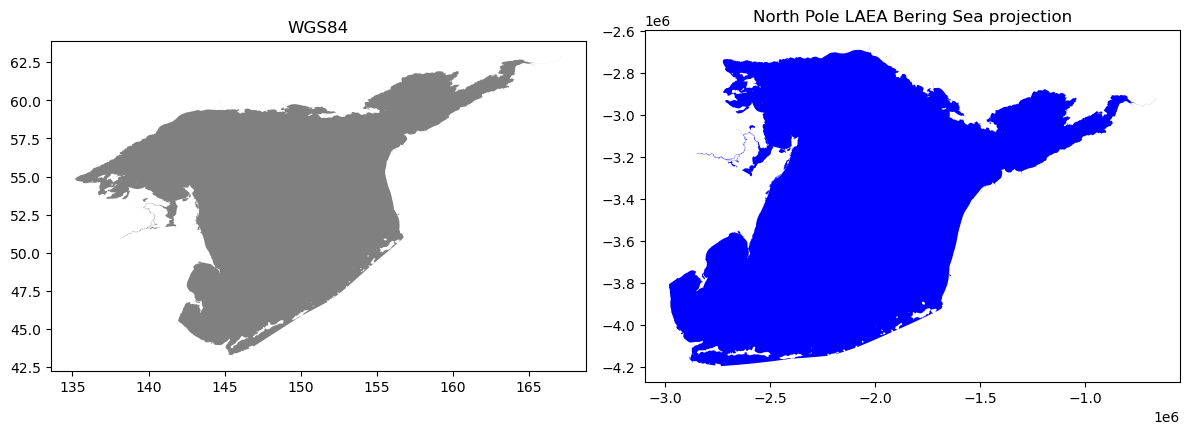

In [5]:
import matplotlib.pyplot as plt

# Selecting geospatial data for the Okhotsk Sea
basin = 'Okhotsk'
data_lamb_Okh = data_lamb[data_lamb.apply(\
                lambda row: row.str.contains(basin, case=False).any(), \
                axis=1)]
data_wgs84_Okh = data_wgs84[data_wgs84.apply(\
                 lambda row: row.str.contains(basin, case=False).any(), \
                 axis=1)]

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Plot the data in WGS84 CRS
data_wgs84_Okh.plot(ax=ax1, facecolor="gray")

# Add title
ax1.set_title("WGS84")

# Plot the one with North Pole LAEA Bering Sea projection
data_lamb_Okh.plot(ax=ax2, facecolor="blue")

# Add title
ax2.set_title("North Pole LAEA Bering Sea projection")

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()


_**Рис. 1**. Карта с границами Охотского моря._

Как видно из рисунка , карты заметно отличаются. Вторая (справа) - лучше сохраняет правильную меру площади, но искажает углы.  Наконец, давайте сохраним наш спроецированный слой в шейп-файл, включив информацию о CRS (`epsg-код`) в имя файла:

In [6]:
# Ouput filepath
outfp = data_folder / 'data_Okhotsk_Sea_3571.shp'

# Save to disk
data.to_file(outfp)

## Характеристики геодезической системы координат (`CRS`)

При работе с географическими данными, полученными из разных источников, вы, вероятно, столкнетесь со многими различными системами координат `CRS`. Время от времени возникает необходимость определять `CRS` с нуля для созднанного или импортированного массива данных. Библиотека `pyproj` предоставляет множество полезных функций для работы с CRS, в том числе создание системы координат как объекта (класса) `CRS`. Далее мы импортируем `CRS` класс из  библиотеки `pyproj` и инициализируем конкретную систему координат, используя метод `.from_epsg()` и `EPSG-код` в качестве входного параметра:

In [7]:
from pyproj import CRS

crs_object = CRS.from_epsg(3571)
crs_object

<Projected CRS: EPSG:3571>
Name: WGS 84 / North Pole LAEA Bering Sea
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 45°N, including Arctic.
- bounds: (-180.0, 45.0, 180.0, 90.0)
Coordinate Operation:
- name: North Pole Lambert Azimuthal Equal Area (Bering Sea)
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Как видите, очень просто инициализировать систему координат с заданным кодом `EPSG`, и аналогичным образом вы можете инициализировать сотни других систем координат, изменив этот код. Сами коды проекций и их описание доступно по ссылке - [EPSG](https://epsg.io/) [3].

Мы также можем легко экспортировать информацию о `CRS` в различные форматы, такие как `WKT-текст` или `PROJ`. Для этого мы можем использовать методы класса `CRS`, такие как `.to_wkt()`,  `.to_proj4()` или `.to_epsg()`. Далее мы экспортируем информацию CRS в строковый формат `PROJ` и обратно в `EPSG`:

In [8]:
crs_proj = crs_object.to_proj4()
print(crs_proj)
print(type(crs_proj))
crs_epsg = CRS(crs_proj).to_epsg()
print(crs_epsg)

+proj=laea +lat_0=90 +lon_0=180 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
<class 'str'>
3571


C:\Users\user\miniconda3\envs\geopy\lib\site-packages\pyproj\crs\crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Обратите внимание, что тип переменной `crs_proj` - str (т.е. строковый), и для экспортирования в исходный формат используется объект/класс `CRS`.

## Создание геопространственных данных `GeoDataFrame` c определенной системой координат `CRS`

Представим, что вам нужно создать новую структуру данных `GeoDataFrame` с нуля и определить `CRS` для ваших данных. Далее мы сначала создадим данные `GeoDataFrame` с двумя точками (географические координаты сильного землетрясения у побережья Японии 11 марта 2011 года и атомной электростанции Фукусима-1 - `Point-объекты`) и линией между ними (`LineString-объект`) без указания `CRS`:

In [9]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Coordinate of earthquake near Honshu
xy_eq = (142.369, 38.322)
xy_fk = (141.0328, 37.42)

# Create a Shapely Points and LineString from the coordinate-tuples
p_eq = Point(xy_eq)
p_fk = Point(xy_fk)
line = LineString([p_eq, p_fk])

# Create GeoDataFrame with Points and LineString objects
newdata = gpd.GeoDataFrame(data=[p_eq, p_fk, line], columns=["geometry"])
newdata

,geometry
0,POINT (142.36900 38.32200)
1,POINT (141.03280 37.42000)
2,"LINESTRING (142.36900 38.32200, 141.03280 37.4..."


Добавим столбец `name` с описанием векторных данных:

In [10]:
# Add a new column and insert data
newdata.at[0, "name"] = "Strong earthquake"
newdata.at[1, 'name'] = 'Fukushima-1 nuclear power plant'
newdata.at[2, 'name'] = 'Tsunami wave path'
newdata

,geometry,name
0,POINT (142.36900 38.32200),Strong earthquake
1,POINT (141.03280 37.42000),Fukushima-1 nuclear power plant
2,"LINESTRING (142.36900 38.32200, 141.03280 37.4...",Tsunami wave path


Выведем информацию о системе координат:

In [11]:
print(newdata.crs)

None


Как мы видим, в данных `GeoDataFrame` на данном этапе `CRS` не указан (`None`), что является проблемой, поскольку ГИС-системы не могут работать с таким набором данных. Мы можем сформировать систему координат `CRS` как отдельный объект, используя метод `CRS.from_epsg()` из библиотеки `pyproj`, и сохранить эту информацию в  атрибуте `.crs` созданных нами геопространственных данных `newdata`:

In [12]:
newdata.crs = CRS.from_epsg(4326)
newdata.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Теперь `.crs` атрибут был обновлен информацией о системе координат, и мы можем, например, перепроецировать данные. Наконец, давайте поэкспериментируем с разными глобальными картографическими проекциями. В этом примере мы также используем данные о границах океанов и морей и нанесем положение места землетрясения:


epsg:4326


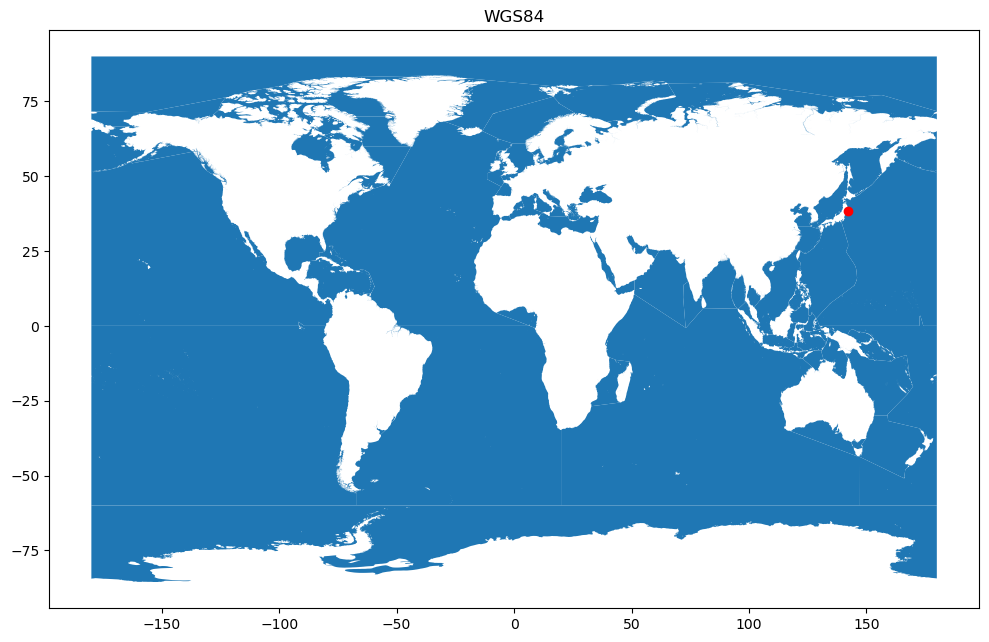

In [13]:
import matplotlib.pyplot as plt

# output crs information
print(data.crs)

# Plot in original crs
fig, ax = plt.subplots(figsize=(12, 12))
data.plot(ax=ax)
newdata.loc[[0]].plot(ax=ax,
                     color='red')
plt.title("WGS84")
plt.show()



_**Рис. 2**. Карта в системе координат WGS84._

Исходные данные представлены в проекции WGS84, которая немного искажает форму материков, особенно в северной и южной частях мира. К счастью, есть и лучшие картографические проекции для визуализации глобальных наборов данных, например равновеликая псевдоцилиндрическая проекция Eckert IV. Для этой проекции нет прямого номера EPSG, но мы можем указать код ESRI (`ESRI:54012`) следующим образом:

ESRI:54012


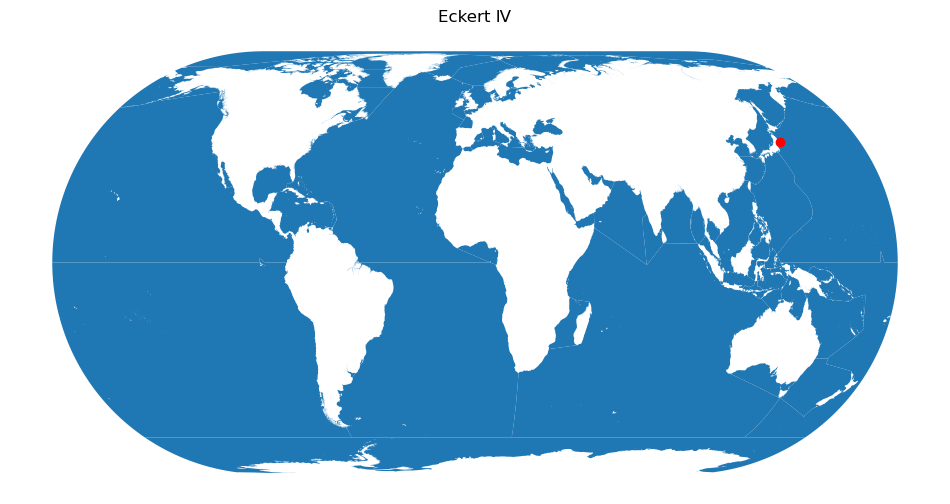

In [14]:
# reproject the data
data_tr = data.to_crs(crs="ESRI:54012")
newdata_tr = newdata.to_crs(crs="ESRI:54012")

# output crs information
print(data_tr.crs)

# Plot in reprojected crs
fig, ax = plt.subplots(figsize=(12, 12))
data_tr.plot(ax=ax)
newdata_tr.loc[[0]].plot(ax=ax,
                     color='red')
plt.title("Eckert Ⅳ")
plt.axis("off")
plt.show()


_**Рис. 3**. Карта границ океанов и морей в проекции `Eckert IV`._

Картографическая проекция `Eckert IV` обеспечивает более сбалансированное представление о мире с меньшими искажениями в северной и южной частях планеты. Наконец, мы также можем определить ортографическую проекцию для нашей карты, которая может быть центрирована в определенной точке (мы выберем Владивосток). Для этого используем специальную строку в формате `PROJ`, и укажем центральную точку с несколькими параметрами системы координат CRS: `+lat`, `+lon` (более подробно о формате `PROJ` см. [здесь](https://proj.org/operations/projections/ortho.html) [5])

+proj=ortho +lat_0=43.11 +lon_0=131.87 +type=crs


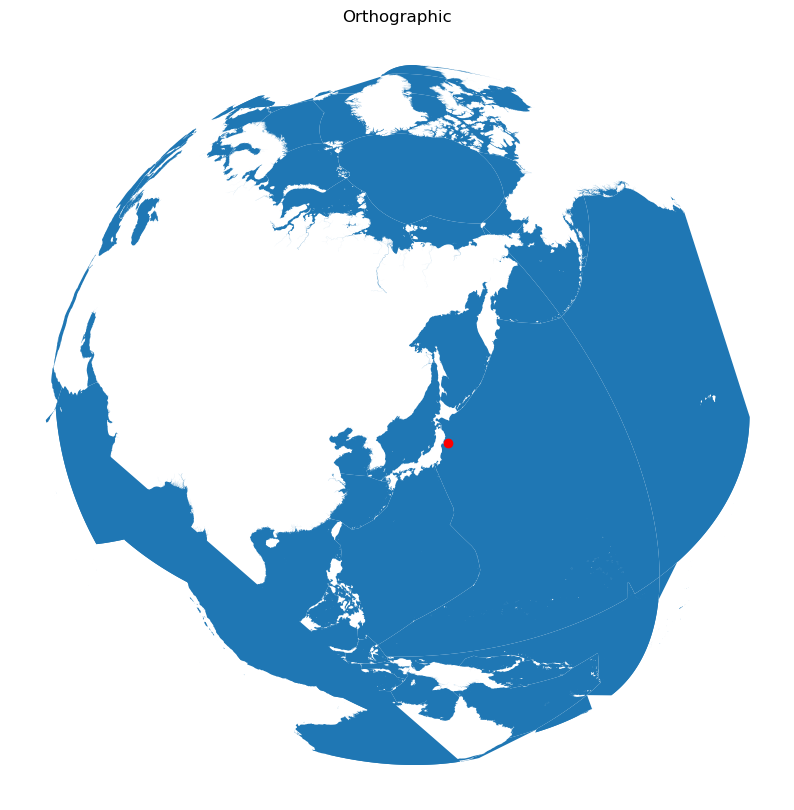

In [15]:
# form PROJ-string with center in Vladivostok
proj_string = "+proj=ortho +lat_0=43.11 +lon_0=131.87"

# construct CRS object in orthographic projection 
ortho = CRS.from_proj4(proj_string)

# reproject the data
data_tr = data.to_crs(ortho)
newdata_tr = newdata.to_crs(ortho)

# output crs information
print(data_tr.crs)

# Plot in reprojected crs
fig, ax = plt.subplots(figsize=(10, 10))
data_tr.plot(ax=ax)
newdata_tr.loc[[0]].plot(ax=ax,
                     color='red')
plt.title('Orthographic')
plt.axis("off")
plt.show()


_**Рис. 4**. Карта границ океанов и морей в ортографической проекции._

Перед нами карта границ океанов и морей с центром во Владивостоке, которая немного напоминает, как Земля выглядела бы из космоса. 

### Задание 2.4

Обратимся к Северному Ледовитому океану.

Как вы знаете арктические морские экосистемы претерпевают существенные изменения, связанные с таянием морского льда и потеплением поверхности. Чрезвычайная изменчивость, наблюдаемая в последние годы в Тихоокеанском секторе Арктики, не имеет аналогов в зарегистрированной истории. В последнее десятилетние все больше океанологических исследований концентрируются в этом регионе.
Тихоокеанский сектор Арктики включает: моря Бофорта, Чукотское, Восточно-Сибирское и Лаптевых.

Визуализируйте карты границ перечисленных морей в двух проекциях - North Pole LAEA Bering Sea (EPSG-код: 3571) и ортографической. Для каждого моря строится отдельный рисунок, состоящий из двух карт в разных проекциях

## Мини-проект <img src="https://vsememy.ru/kartinki/wp-content/uploads/2023/04/1675522569_papik-pro-p-perchik-risunok-1.png" width="40" height="30">

Сформировать `geojson-файл`, содержащий структуру данных `GeoDataFrame` со следующими векторными объектами:
- границы морской экспериментальной станции "м. Шульца" в виде `Polygon-объекта` (исходный файл - [Schultz_boundary.geojson](https://drive.google.com/file/d/1lEn1bXT8P4syvWuT62OodFRs_il9R3-W/view?usp=share_link) [6] - расположен на google-диске в папке дисциплины);
- здание в виде `Polygon-объекта` c координатами углов (longitude, latitude):
    (131.1632086, 42.5813548),
    (131.1633552, 42.5813101),
    (131.1632551, 42.5811179),
    (131.1631050, 42.5811626);
- дорога в виде `LineString-объекта` (исходный файл - [Schultz_road.geojson](https://drive.google.com/file/d/1vs2iRYQ-L3za0JmBRICtn__H8Xp9uUQG/view?usp=share_link) [7] - расположен на google-диске в папке дисциплины);
- положение условного судна в виде `Point-объекта` c координатами `(131.1635, 42.5855)`

Перепроецировать геопространственные данные из исходной системы координат - в десятичных градусах - (`EPSG:4326`) в проекцию UTM zone 52N - в метрах - (`EPSG:32652`).

Добавить в структуру данных `GeoDataFrame` следующие поля:
- название (столбец `name`);
- координаты геометрического центра тяжести (столбцы `centroid_x` и `centroid_y`);
- для `Polygon-объектов`, площадь в м2 (столбец `area_m2`); для остальных объектов - 0;
- минмальные (`minx`, `miny`) и максимальные (`maxx`, `maxy`) значения координат x и y.

Визуализируйте векторные объекты на карте (каждый своим цветом)

Рассчитайте и выведите на экран:
- площадь морской экспериментальной станции (в га)
- протяженность дороги (в м)
- кратчайшее расстояние от судна до берега (в м)

### Список использованных источников

1. https://docs.google.com/presentation/d/1H7uC7v5pxSXzzj8bV2lTUxVPdtpEIdgV/edit?usp=share_link&ouid=115514344162264440713&rtpof=true&sd=true
2. https://www.marineregions.org/download_file.php?name=World_Seas_IHO_v3.zip
3. https://epsg.io/
4. https://epsg.io/3571
5. https://proj.org/operations/projections/ortho.html
6. https://drive.google.com/file/d/1lEn1bXT8P4syvWuT62OodFRs_il9R3-W/view?usp=share_link
7. https://drive.google.com/file/d/1vs2iRYQ-L3za0JmBRICtn__H8Xp9uUQG/view?usp=share_link